# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

## Imports

In [1]:
import sklearn.model_selection
import torch
import torch.nn.functional as F
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import datetime as dt
import gensim 
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import sklearn.metrics

In [2]:
import matplotlib.pyplot as plt

## Functions

In [3]:
def preprocess(doc):
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    words = [t.lemma_ for t in nlp(doc) if t.lemma_ != '-PRON-']
    return ' '.join(words).lower()

In [4]:
def pca_loadings(v):
    pca = TruncatedSVD(2)
    pca.fit(v)
    return pca.components_.T

In [5]:
def generate_vocab(vector):
    text_str = vector.str.cat(sep=' ').lower()
    text_list = text_str.split()
    text_unique = list(set(text_list))
    return text_unique

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
def train(V, y, components, epochs):
    try:
        V = V.toarray()
    except AttributeError:
        pass

    Y = torch.tensor(y, dtype=torch.float32)
    X = torch.tensor(V, dtype=torch.float32)

    C = torch.tensor(components, dtype=torch.float32, requires_grad=True)
    beta = torch.randn((components.shape[0], 1), requires_grad=True)

    opt = torch.optim.Adam([C, beta], lr=0.01)
    criterion = torch.nn.BCELoss()

    for i in range(epochs):
        L = torch.mm(X, C.T)
        out = torch.mm(L, beta)
        p = torch.sigmoid(out)
        loss = criterion(p, Y)

        if i % 20 == 0:
            print(f"[ {timestamp()} ] :: Epoch {i:02} :: {loss.item():0.6f}")

        loss.backward()
        opt.step()
        opt.zero_grad()

    return C.detach().numpy()

In [8]:
def test(V, y, components):
    try:
        V = V.toarray()
    except AttributeError:
        pass

    Y = torch.tensor(y, dtype=torch.float32)
    X = torch.tensor(V, dtype=torch.float32)

    C = torch.tensor(components, dtype=torch.float32, requires_grad=True)
    beta = torch.randn((components.shape[0], 1), requires_grad=True)

    #opt = torch.optim.Adam([C, beta], lr=0.01)
    criterion = torch.nn.BCELoss()
    
    L = torch.mm(X, C.T)
    out = torch.mm(L, beta)
    p = torch.sigmoid(out)
    loss = criterion(p, Y)
    print(f"[ {timestamp()} ] :: Test loss: {loss.item():0.6f}")
    return loss

In [9]:
def tokenize_X(X):
    return X.apply(lambda x: word_tokenize(x.lower()))

In [10]:
def generate_word_vectors(X):
    X_tokens = tokenize_X(X)
    model_cbow = gensim.models.Word2Vec(list(X_tokens.values),
                                        min_count = 1,  
                                        size = 100,
                                        window = 5)
    return model_cbow.wv

In [11]:
def timestamp():
    return dt.datetime.now().strftime("%Y/%m/%d %H:%M:%S")

In [12]:
def map_to_wordvec(token_line, word_vectors):
    return np.array(np.sum(np.array([word_vectors[token] for token in token_line]), axis=0))


In [13]:
def encode_data(X):
    X_tokens = tokenize_X(X)
    X_wv = X_tokens.apply(map_to_wordvec, args=(word_vec,))
    return X_wv.apply(pd.Series).values

---

### Load Data

In [14]:
sample_fraction = 0.3

stemmer = SnowballStemmer("english")
not_alphanumeric_or_space = re.compile(r'[^(\w|\s|\d)]')
nlp = spacy.load('en_core_web_sm')

print(f"[ {timestamp()} ] :: Loading from file...")
yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=sample_fraction)
# There are three extra rows that are labelled positive, I dropped them
yelps = yelps.loc[yelps.positive!='positive'] 
yelps = yelps[['positive', 'text']]

X = yelps['text']
# Beacause of the extra rows, the positive column is a string,
# so I map it back to an int
y = yelps['positive'].map({'True': 1, 'False': 0}).values

[ 2020/05/17 21:05:34 ] :: Loading from file...


### TFID

In [15]:
vocab = generate_vocab(X)

print(f"[ {timestamp()} ] :: Creating vectoriser...")
vectorizer = TfidfVectorizer(min_df=2,
                             max_df=.8,
                             preprocessor=preprocess,
                             stop_words='english',
                             vocabulary = vocab,
                             use_idf=True,
                             norm=False)


reviews = list(X.apply(lambda x: x.split()).values)

mult = [1,10,50,80]
train_size_base = 0.01
epochs = 100

losses = []
for m in mult:
    train_size = train_size_base * m
    print(f"*---"*10)
    print(f"[ {timestamp()} ] :: Train size: {train_size}")
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,train_size = train_size)

    print(f"[ {timestamp()} ] :: Fitting transform for training...")
    v_train = vectorizer.fit_transform(X_train)
    v_train = np.asarray(v_train.todense())
    word_vecs = pca_loadings(v_train)

    print(f"[ {timestamp()} ] :: Training...")
    learned_vecs = train(v_train, y_train, word_vecs.T, epochs)

    print(f"[ {timestamp()} ] :: Fitting transform for testing...")
    v_test = vectorizer.fit_transform(X_test)
    v_test = np.asarray(v_test.todense())

    print(f"[ {timestamp()} ] :: Testing...")
    loss = test(v_test, y_test, learned_vecs)

    losses.append({"train_size" : train_size, "loss": loss.item()})
    print(f"\n")
    #print(f"*---"*10)
tfid_loss = pd.DataFrame(losses)

[ 2020/05/17 21:05:36 ] :: Creating vectoriser...
*---*---*---*---*---*---*---*---*---*---
[ 2020/05/17 21:05:36 ] :: Train size: 0.01
[ 2020/05/17 21:05:36 ] :: Fitting transform for training...


/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[ 2020/05/17 21:05:49 ] :: Training...
[ 2020/05/17 21:05:49 ] :: Epoch 00 :: 3.421689


/anaconda3/envs/r_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([299])) that is different to the input size (torch.Size([299, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[ 2020/05/17 21:05:50 ] :: Epoch 20 :: 0.003306
[ 2020/05/17 21:05:51 ] :: Epoch 40 :: 0.000922
[ 2020/05/17 21:05:52 ] :: Epoch 60 :: 0.000602
[ 2020/05/17 21:05:53 ] :: Epoch 80 :: 0.000479
[ 2020/05/17 21:05:54 ] :: Fitting transform for testing...
[ 2020/05/17 21:18:32 ] :: Testing...


/anaconda3/envs/r_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([29700])) that is different to the input size (torch.Size([29700, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[ 2020/05/17 21:19:42 ] :: Test loss: 0.815917


*---*---*---*---*---*---*---*---*---*---
[ 2020/05/17 21:19:42 ] :: Train size: 0.1
[ 2020/05/17 21:19:43 ] :: Fitting transform for training...
[ 2020/05/17 21:21:12 ] :: Training...


/anaconda3/envs/r_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([2999])) that is different to the input size (torch.Size([2999, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[ 2020/05/17 21:21:13 ] :: Epoch 00 :: 2.877246
[ 2020/05/17 21:21:20 ] :: Epoch 20 :: 0.029786
[ 2020/05/17 21:21:27 ] :: Epoch 40 :: 0.016018
[ 2020/05/17 21:21:34 ] :: Epoch 60 :: 0.013308
[ 2020/05/17 21:21:42 ] :: Epoch 80 :: 0.012202
[ 2020/05/17 21:21:49 ] :: Fitting transform for testing...
[ 2020/05/17 21:33:07 ] :: Testing...


/anaconda3/envs/r_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([27000])) that is different to the input size (torch.Size([27000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[ 2020/05/17 21:34:24 ] :: Test loss: 13.304457


*---*---*---*---*---*---*---*---*---*---
[ 2020/05/17 21:34:24 ] :: Train size: 0.5
[ 2020/05/17 21:34:25 ] :: Fitting transform for training...
[ 2020/05/17 21:50:06 ] :: Training...


/anaconda3/envs/r_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([14999])) that is different to the input size (torch.Size([14999, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[ 2020/05/17 21:50:57 ] :: Epoch 00 :: 5.467865
[ 2020/05/17 21:55:51 ] :: Epoch 20 :: 0.071873
[ 2020/05/17 22:00:38 ] :: Epoch 40 :: 0.035030
[ 2020/05/17 22:05:43 ] :: Epoch 60 :: 0.023990
[ 2020/05/17 22:10:30 ] :: Epoch 80 :: 0.018680
[ 2020/05/17 22:15:50 ] :: Fitting transform for testing...
[ 2020/05/17 22:24:48 ] :: Testing...


/anaconda3/envs/r_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([15000])) that is different to the input size (torch.Size([15000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[ 2020/05/17 22:25:38 ] :: Test loss: 0.656121


*---*---*---*---*---*---*---*---*---*---
[ 2020/05/17 22:25:38 ] :: Train size: 0.8
[ 2020/05/17 22:25:40 ] :: Fitting transform for training...
[ 2020/05/17 22:53:51 ] :: Training...


/anaconda3/envs/r_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([23999])) that is different to the input size (torch.Size([23999, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[ 2020/05/17 22:55:40 ] :: Epoch 00 :: 0.666608
[ 2020/05/17 23:08:30 ] :: Epoch 20 :: 0.114527
[ 2020/05/17 23:17:17 ] :: Epoch 40 :: 0.033019
[ 2020/05/17 23:25:29 ] :: Epoch 60 :: 0.016074
[ 2020/05/17 23:33:42 ] :: Epoch 80 :: 0.010036
[ 2020/05/17 23:41:27 ] :: Fitting transform for testing...
[ 2020/05/17 23:44:09 ] :: Testing...


/anaconda3/envs/r_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([6000])) that is different to the input size (torch.Size([6000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[ 2020/05/17 23:44:18 ] :: Test loss: 0.627252




### Word2Vec

In [16]:
print(f"[ {timestamp()} ] :: Generating Word Vectors")
word_vec = generate_word_vectors(X)

mult = [1,10,50,80]
train_size_base = 0.01

w2v_losses = []
for m in mult:
    train_size = train_size_base * m
    print(f"*---"*10)
    print(f"[ {timestamp()} ] :: Train size: {train_size}")
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,train_size = train_size)

    print(f"[ {timestamp()} ] :: Regressing...")
    lr = LogisticRegression(random_state=0,
                            solver='lbfgs', 
                            max_iter=10000)
    clf = lr.fit(encode_data(X_train), y_train)

    y_pred = clf.predict(encode_data(X_test))
    loss = sklearn.metrics.log_loss(y_test, y_pred)

    w2v_losses.append({"train_size" : train_size, "loss": loss.item()})
w2v_loss = pd.DataFrame(w2v_losses)

[ 2020/05/17 23:44:19 ] :: Generating Word Vectors
*---*---*---*---*---*---*---*---*---*---
[ 2020/05/17 23:45:46 ] :: Train size: 0.01
[ 2020/05/17 23:45:46 ] :: Regressing...
*---*---*---*---*---*---*---*---*---*---
[ 2020/05/17 23:46:39 ] :: Train size: 0.1
[ 2020/05/17 23:46:39 ] :: Regressing...
*---*---*---*---*---*---*---*---*---*---
[ 2020/05/17 23:47:32 ] :: Train size: 0.5
[ 2020/05/17 23:47:32 ] :: Regressing...
*---*---*---*---*---*---*---*---*---*---
[ 2020/05/17 23:48:27 ] :: Train size: 0.8
[ 2020/05/17 23:48:27 ] :: Regressing...


### Plotting the Comparison

In [17]:
tfid_loss.columns = ['train_size', 'tfid_loss']
w2v_loss.columns = ['train_size', 'w2v_loss']

In [18]:
combined = tfid_loss.merge(w2v_loss, on='train_size')

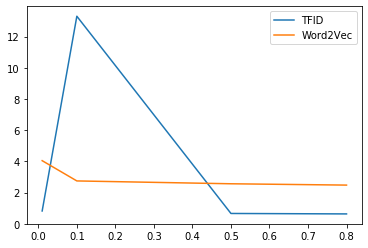

In [19]:
plt.plot(combined['train_size'], combined['tfid_loss'], label='TFID')
plt.plot(combined['train_size'], combined['w2v_loss'], label='Word2Vec')
plt.legend()